In [44]:
import re
from PIL import Image
import pytesseract
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from rtree import index
from dataclasses import dataclass
from typing import List
import json


In [163]:
PATH = "/content/samplerenewalformEdited.jpg"
image = cv2.imread(PATH)
text = pytesseract.image_to_string(Image.open(PATH), config='--dpi 440 -l eng')
print(text)


 

 

FORM 9
[See Rule 18(1)]
FORM OF APPLICATION FOR THE RENEWAL OF DRIVING LICENCE

 

Space for
Passport
size
photograph

 

I, Shri/Smt./Kumari Manoj Kumar

 

 

Son/Wife/Daughter of... Satish Kumar hereby apply for the renewal of my

 

 

driving licence which is attached and particulars of which are as follows:

 

 

 

 

 

 

 

 

(a) Number : HR-2039474809
(b) Date of issue : 02-07-2010
(c) Licensing authority by which the: RTO Gurugram
licence was issued
(d) Licensing authority by which the: RTO Gurugram
licence was last renewed
No. and date of renewal 4
(e) Class of vehicles authorized to be LCV, LMV
driven S :
(f) Date of expiry of licence to drive
(i) Transport vehicle : 02-03-2020
(ii) Vehicles other than transport , 28-02-2020
vehicles ooo
My present address is 3 H.No. - 909, Sector 33F

 

Gurugram, Haryana - 122003

 

If this address is not entered on the licence, I do / do not wish that it should be so entered.
If the licence is not attached, reasons why it is n

In [164]:
name_pattern = r'I,\s+((?:Shri\s*/\s*Smt\.?\s*/\s*Kumari))\s+([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)'
parent_pattern = r'(Son|Wife|Daughter)\s*/\s*(?:Son|Wife|Daughter)?\s*of\.?\s+([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)'
number_pattern = r'Number\s+.*?([A-Z]{2}-\d{10})'
date_pattern = r'Date of issue\s+.*?(\d{2}-\d{2}-\d{4})'
pattern_issued = r'Licensing authority by which the\s*:\s*([^\n]+)\n.*?issued'
pattern_renewed = r'Licensing authority by which the\s*:\s*([^\n]+)\n.*?renewed'
pattern_renewel_date = r'Date of renewal\s*:\s*(\d{2}-\d{2}-\d{4})?'
class_pattern = r'Class of vehicles authorized to be\s+([^\n:]+)\s*driven'
pattern_transport = r'Transport vehicle\s*[:.]\s*(\d{2}-\d{2}-\d{4})'
pattern_non_transport = r'Vehicles other than transport\s*[:.,]?\s*(\d{2}-\d{2}-\d{4})'
pattern_address = r'My present address is\s*[:\d\s]*\s*(.+?)(?=\nIf this address)'

pattern_reason_not_attached = r'If the licence is not attached, reasons why it is not available\?\s*(.+?)(?=\nIf the licence was not renewed)'
pattern_reason_renewal_delay = r'If the licence was not renewed within thirty days.*?reasons for delay\s*(.+?)(?=\nThe renewal of licence has not been refused by any licensing authority\.)'
pattern_fee = r'I\s*have\s*paid\s*the\s*fee\s*of\s*Rs\s*(\d+)?'


def extract_info(text):
    data = {}

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30,30))

    if len(faces) > 0:
        data['Photo'] = "Present"
    else:
        data['Photo'] = "Missing"

    # Name
    match = re.search(name_pattern, text)
    if match:
        data['Name'] = match.group(2).strip()

    # Parent / Guardian
    match = re.search(parent_pattern, text)
    if match:
        data['Relative_Name'] = match.group(2).strip()

    # Number
    match = re.search(number_pattern, text)
    if match:
        data['Number'] = match.group(1).strip()

    # Date of Issue
    match = re.search(date_pattern, text)
    if match:
        data['Date_of_Issue'] = match.group(1).strip()

    # Licensing authority
    match = re.search(pattern_issued, text, re.IGNORECASE)
    if match:
        data['Issued_by'] = match.group(1).strip()

    match = re.search(pattern_renewed, text, re.IGNORECASE)
    if match:
        data['Last_Renewed_by'] = match.group(1).strip()

    # Renewal Date
    match = re.search(pattern_renewel_date, text, re.IGNORECASE)
    data['Date_of_Renewal'] = match.group(1).strip() if match and match.group(1) else None

    # Class of Vehicles
    match = re.search(class_pattern, text, re.IGNORECASE)
    if match:
        data['Class_of_Vehicles'] = match.group(1).strip()

    # Vehicle Expiry Dates
    match = re.search(pattern_transport, text, re.IGNORECASE)
    data['Transport_Vehicle_Expiry'] = match.group(1).strip() if match else None

    match = re.search(pattern_non_transport, text, re.IGNORECASE)
    data['Non_Transport_Vehicle_Expiry'] = match.group(1).strip() if match else None

    # Address
    match = re.search(pattern_address, text, re.DOTALL | re.IGNORECASE)
    if match:
        address = match.group(1).replace('\n', ' ').strip()
        data['Present_Address'] = address

    # Reason if licence not attached
    match = re.search(pattern_reason_not_attached, text, re.DOTALL | re.IGNORECASE)
    data['Reason_Not_Attached_Question'] = match.group(0).strip() if match else None
    data['Reason_Not_Attached_Answer'] = match.group(1).strip() if match and match.group(1).strip() else None

    # Reason for renewal delay
    match = re.search(pattern_reason_renewal_delay, text, re.DOTALL | re.IGNORECASE)
    data['Reason_Renewal_Delay_Question'] = match.group(0).strip() if match else None
    data['Reason_Renewal_Delay_Answer'] = match.group(1).strip() if match and match.group(1).strip() else None

    #Fee
    match = re.search(pattern_fee, text, re.IGNORECASE)
    data['Fee_Paid'] = match.group(1) if match and match.group(1) else None

    return data

info = extract_info(text)
for key, value in info.items():
    print(f"{key}: {value}")


Photo: Missing
Name: Manoj Kumar
Number: HR-2039474809
Date_of_Issue: 02-07-2010
Issued_by: RTO Gurugram
Last_Renewed_by: RTO Gurugram
Date_of_Renewal: None
Class_of_Vehicles: LCV, LMV
Transport_Vehicle_Expiry: 02-03-2020
Non_Transport_Vehicle_Expiry: 28-02-2020
Present_Address: H.No. - 909, Sector 33F     Gurugram, Haryana - 122003
Reason_Not_Attached_Question: If the licence is not attached, reasons why it is not available?
Reason_Not_Attached_Answer: None
Reason_Renewal_Delay_Question: If the licence was not renewed within thirty days of the date of expiry, reasons for delay
Reason_Renewal_Delay_Answer: None
Fee_Paid: None


JSON

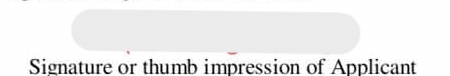

True

In [165]:
height, width = image.shape[:2]
x_start = width - 550
y_start = height - 251
x_end = width - 100
y_end = height - 175
cropped = image[y_start:y_end, x_start:x_end]
cv2_imshow(cropped)
cropped_path = "/content/signature_crop.png"
cv2.imwrite(cropped_path, cropped)

In [166]:
fields_to_extract = ["Number", "Date_of_Issue", "Class_of_Vehicles", "Issued_by", "Fee_paid"]
extracted_data = {key: info.get(key, None) for key in fields_to_extract}
extracted_data["Signature_Path"] = cropped_path
json_data = json.dumps(extracted_data, indent=4)
print(json_data)


{
    "Number": "HR-2039474809",
    "Date_of_Issue": "02-07-2010",
    "Class_of_Vehicles": "LCV, LMV",
    "Issued_by": "RTO Gurugram",
    "Fee_paid": null,
    "Signature_Path": "/content/signature_crop.png"
}
